In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.utils.data as data
import torch.nn.functional as F

import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

import nltk 
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
!nvidia-smi

Mon Sep 27 15:29:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Data Preparation

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df=pd.read_csv('/content/drive/MyDrive/csvFiles/Dataset 3.csv',encoding = "ISO-8859-1")
df.head()

,tweets,sentiment
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


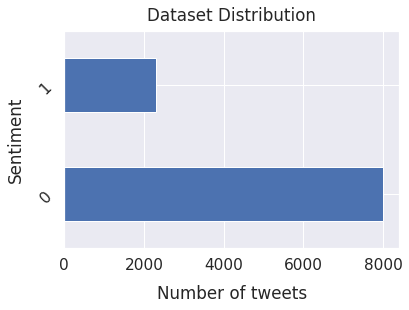

In [10]:
sns.set(font_scale=1.4)
df['sentiment'].value_counts().plot(kind='barh', figsize=(6,4))
plt.xlabel('Number of tweets', labelpad=12)
plt.ylabel('Sentiment', labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

### Data Cleaning

In [12]:
def cleaning(text):
  text=text.lower()
  text=re.sub(r"(@[A-Za-z0-9]+)|(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", str(text))

  stop = stopwords.words('english')
  text = " ".join([word for word in text.split() if word not in (stop)])

  return text

df['cleaned_tweets']=df['tweets'].apply(cleaning)

indices=[2500, 3000, 5000, 7800, 9700]
for i in indices:
    print('Original Data--> ',df['tweets'][i])
    print('Cleaned Data--> ',df['cleaned_tweets'][i])
    print('Sentiment--> ',df['sentiment'][i])
    print('\n')

Original Data-->  @highheelznkickz its ok; the 1st step is deniallll  LOL
Cleaned Data-->  ok 1st step deniallll lol
Sentiment-->  0


Original Data-->  @Teamcyrus I love you! I dont think i have ever met anyone as kind as you! And well done for getting 1000 followers! 
Cleaned Data-->  love dont think ever met anyone kind well done getting 1000 followers
Sentiment-->  0


Original Data-->  @Clareies  whip out out the after sun and moisturiser!
Cleaned Data-->  whip sun moisturiser
Sentiment-->  0


Original Data-->  http://twitpic.com/7j5nc - breakfast after a long night 
Cleaned Data-->  breakfast long night
Sentiment-->  0


Original Data-->  distant myself for it then dwell on my misery and trigger my depression not that I have being happy or feeling good about myself these past days . So yeah I wanna take a break from it all and just spend time doing stuff I like/love
Cleaned Data-->  distant dwell misery trigger depression happy feeling good past days yeah wanna take break spend 

### Removing Empty Data

In [13]:
df['Length']=df['cleaned_tweets'].apply(lambda x: len(x.split()))
print('Total Tweets: ',len(df))
dataset=df.loc[df.Length>0]
dataset=dataset.reset_index(drop=True)
print('Removed Tweets:  ',len(df)-len(dataset))
print('Total Tweets:  ',len(dataset))

Total Tweets:  10314
Removed Tweets:   34
Total Tweets:   10280


### Dataset Analysis

In [20]:
class_labels=[k for k,v in dataset['sentiment'].value_counts().to_dict().items()]
    
documents=[]
words=[]
u_words=[]
total_words=[word.strip() for t in list(df['cleaned_tweets']) for word in t.strip().split()]

def data_summary(dataset):
    print('Total Words:  {}\n'.format(len(total_words)))
    for label in class_labels:
        words_list = [word for t in dataset[dataset.sentiment==label].cleaned_tweets for word in t.strip().split()]
        
        counts=dict()
        for w in words_list:
            counts[w]=counts.get(w,0)+1
        
        ordered=sorted(counts.items(), key=lambda x:x[1], reverse=True)
        
        documents.append(len(list(dataset[dataset.sentiment==label].cleaned_tweets)))
        u_words.append(len(np.unique(words_list)))
        words.append(len(words_list))
        
        print('Category:-->{}'.format(label))
        print('Number of documents:-->{}'.format(len(list(dataset[dataset.sentiment==label].cleaned_tweets))))
        print('Number of Words:-->{}'.format(len(words_list)))
        print('Number of Unique Words-->{}'.format(len(np.unique(words_list))))
        
        print('Most Unique Words: \n')
        for k,v in ordered[:10]:
            print('{}--->{}'.format(k,v))
        print('\n')
    
    print('Total Unique Words:  {}'.format(len(np.unique(total_words))))

In [21]:
data_summary(dataset)

Total Words:  86021

Category:-->0
Number of documents:-->7966
Number of Words:-->56177
Number of Unique Words-->11712
Most Unique Words: 

good--->616
day--->491
love--->478
quot--->427
lol--->399
get--->369
like--->358
thanks--->347
time--->323
today--->321


Category:-->1
Number of documents:-->2314
Number of Words:-->29844
Number of Unique Words-->7236
Most Unique Words: 

depression--->2367
anxiety--->392
emoji--->343
twitter--->299
com--->281
pic--->280
face--->205
like--->199
people--->163
know--->129


Total Unique Words:  15748


### Summary Visualization

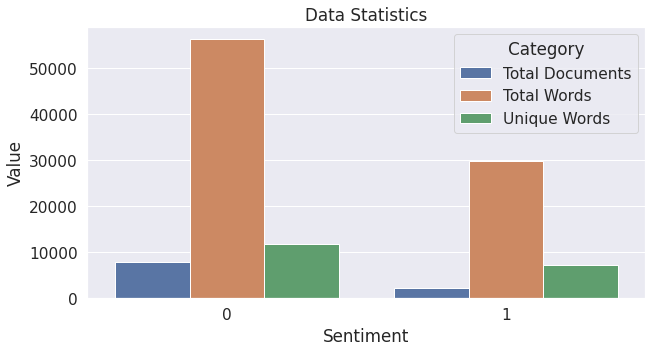

In [22]:
data_matrix=pd.DataFrame({'Total Documents': documents,
                         'Total Words': words,
                         'Unique Words': u_words,
                         'Sentiment': class_labels})

d=pd.melt(data_matrix,id_vars='Sentiment', var_name='Category', value_name='Value')
plt.figure(figsize=(10,5))
ax=plt.subplot()

sns.barplot(data=d, x='Sentiment', y='Value', hue='Category')
ax.set_xlabel('Sentiment')
ax.set_title('Data Statistics');

### Headline Length Distribution

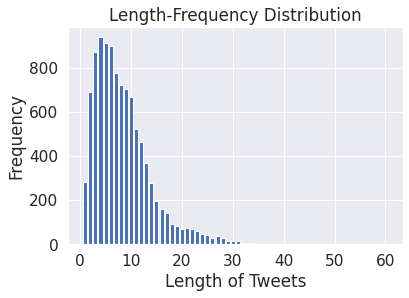

Maximum Length of a tweet: 60
Minimum Length of a tweet: 1
Average Length of a tweet: 8.0


In [23]:
text_lengths=list(dataset['cleaned_tweets'].apply(lambda x:len(x.split())))
frequencies=dict()
for l in text_lengths:
    frequencies[l]=frequencies.get(l,0)+1

plt.bar(x=frequencies.keys(), height=frequencies.values());
plt.xlabel('Length of Tweets')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a tweet: {max(text_lengths)}")
print(f"Minimum Length of a tweet: {min(text_lengths)}")
print(f"Average Length of a tweet: {round(np.mean(text_lengths),0)}")

### Label Encoding and Dataset Splitting

In [24]:
def label_encoding(category):
    le=LabelEncoder()
    le.fit(category)
    encoded_labels=np.array(le.transform(category))
    
    sample_ids=[1000,9120,23]
    for i in sample_ids:
        print('{}--->{}'.format(category[i], encoded_labels[i]))
    return encoded_labels

In [25]:
labels=label_encoding(dataset.sentiment)

0--->0
1--->1
0--->0


In [28]:
def dataset_splitting(tweets, category):
    X,X_test,y,y_test=train_test_split(tweets, category, train_size=0.8, test_size=0.2, random_state=0)
    X_train, X_valid, y_train, y_valid=train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=0)
    
    print('Dataset Distribution:\n')
    print('\tSet\t\tData')
    print("\t========\t======")
    print('\tTotal:\t\t{}'.format(len(tweets)))
    print('\tTrain:\t\t{}'.format(len(X_train)))
    print('\tTest:\t\t{}'.format(len(X_test)))
    print('\tValid:\t\t{}'.format(len(X_valid)))
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [29]:
X_train,X_valid,X_test,y_train,y_valid,y_test=dataset_splitting(dataset.cleaned_tweets, labels)

Dataset Distribution:

	Set		Data
	========	======
	Total:		10280
	Train:		6579
	Test:		2056
	Valid:		1645


### Tokenization and Word Embedding

In [30]:
tokens = nltk.word_tokenize(X_train.iloc[5000])
tokens

['rain',
 'dark',
 'sky',
 'muddy',
 'streaks',
 'reflect',
 'depression',
 'vibrant',
 'colors',
 'reflect',
 'state',
 'happiness',
 'state',
 'mind',
 'clouds',
 'wanting',
 'see',
 'colors',
 'feel',
 'pain',
 'key',
 'emoji',
 'key',
 'wan',
 'na',
 'fly',
 'high',
 'sky',
 'emoji',
 'sparkles']

In [31]:
def load_glove_model(glove_file):
  f = open(glove_file, 'r', encoding='utf-8')
  glove_model = {}
  
  for line in f:
    split_line = line.split()
    word = split_line[0]
    embedding = np.array([float(val) for val in split_line[1:]])
    glove_model[word] = embedding
  return glove_model

In [33]:
glove_100d=load_glove_model('glove.6B.100d.txt')

In [37]:
glove_100d['says']

array([ 0.13742 ,  0.52508 ,  0.50094 , -0.74136 ,  0.13468 , -0.40371 ,
       -0.50229 ,  0.25079 ,  0.41697 ,  0.10341 , -0.041446, -0.025218,
        0.28372 ,  0.35165 , -0.20286 ,  0.16248 , -0.11873 , -0.033485,
       -0.43811 ,  0.89573 ,  0.048899,  0.2746  ,  0.14668 ,  0.16552 ,
        0.035335,  0.63623 , -0.50517 , -1.0775  , -0.18428 , -0.13318 ,
       -0.25741 ,  1.208   , -0.13687 ,  0.21086 , -0.029814,  0.18402 ,
        0.27063 ,  0.2435  ,  0.30211 , -0.27794 , -1.0233  ,  0.083094,
        0.23371 , -0.25094 , -0.5207  , -0.19847 , -0.52875 , -0.68783 ,
       -0.33532 , -0.59114 ,  0.78681 , -0.64765 ,  0.055483,  0.93429 ,
       -0.18895 , -2.3452  , -0.26689 ,  0.18635 ,  0.90769 ,  0.63425 ,
        0.72957 ,  0.22406 ,  0.29788 , -0.72107 ,  0.64362 , -0.17202 ,
        0.90225 ,  0.8747  ,  0.017163,  0.5374  ,  0.79546 , -0.15353 ,
       -0.2891  , -0.40681 ,  0.68275 , -0.15397 ,  0.36546 ,  0.011133,
       -1.1458  ,  0.096262,  0.92523 , -0.44603 , 

In [38]:
len(glove_100d)

1225

In [43]:
def embed_tweet(tweets):
    lst=[]
    lst_pad=[[0]*100]*60

    words=nltk.word_tokenize(tweets) 
      
    n=len(words)
  
    for t in words:
        try:
            embedded=list(glove_100d[t])
            lst.append(embedded)
        except:
            lst.append(list(np.random.rand(100)))
    
    lst_pad[:n]=lst
    embedding=np.array(lst_pad)

    embedding=torch.from_numpy(embedding)
    embedding=embedding.float()

    return embedding

In [44]:
embed_tweet(X_train.iloc[6300])

tensor([[0.9819, 0.6340, 0.7461,  ..., 0.5930, 0.8600, 0.1869],
        [0.6526, 0.4808, 0.8959,  ..., 0.2584, 0.8777, 0.0378],
        [0.8844, 0.0653, 0.4569,  ..., 0.5984, 0.7527, 0.4616],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [45]:
le=LabelEncoder()
le.fit(dataset['sentiment'])
le.classes_
le.inverse_transform([y_train[6300]])

array([0])

### Dataset Creation

In [46]:
class TextDataset(data.Dataset):
    def __init__(self, tweets, label):
        super(TextDataset, self).__init__()
        
        self.tweets=list(tweets)
        self.labels=label
        
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, idx):
        h=self.tweets[idx]
        a=self.labels[idx]
        
        #print('Text:  ',h)
        embedding=embed_tweet(h)
        #print('Answer: ',le.inverse_transform([a]))
        
        return embedding,a

In [47]:
train_set=TextDataset(X_train,y_train)
train_set.__getitem__(6300)

(tensor([[0.0978, 0.8447, 0.6451,  ..., 0.0062, 0.0014, 0.3093],
         [0.8526, 0.7382, 0.2727,  ..., 0.3998, 0.0305, 0.4559],
         [0.1749, 0.4063, 0.2577,  ..., 0.9529, 0.2486, 0.7678],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]), 0)

In [48]:
train_set.tweets

['going bed night guys',
 'hey wondering whereabouts uganda guys went im going july wondering im going place xx',
 'okay take tomorrow going use one already needs new roller love typewriters',
 'afraid use 4 letter words',
 'hi xaviermedia found way get thousands twitter followers check',
 'looking forward evry song love love xoxox sophie please please reply',
 'irish german spunk mix',
 'ok ok depression mentalhealth lovelife workhard smile happy beautifullife lovelife goals keepontrying summeriscoming',
 'pleasure great site use lot iphone ringtones',
 'lmao try stop visiting everyone tomorrow',
 'sun shining going studio go sea problem',
 'playing wsop ladies event tomorrow let ya know goes',
 'quote day quot walk softly carry big magnifying glass quot richard lacayo',
 'got bb bac function',
 'depression hits anxiety',
 'christian read persecution alot recieve alotsince march',
 'mmmmmm thats pretty much route im going reckons',
 'night babies got vh1 thing check pics',
 'jenn want

In [49]:
valid_set=TextDataset(X_valid,y_valid)
valid_set.__getitem__(1)

(tensor([[0.0738, 0.1046, 0.8416,  ..., 0.9482, 0.6205, 0.3954],
         [0.2455, 0.6773, 0.7534,  ..., 0.8497, 0.1132, 0.8787],
         [0.6855, 0.1678, 0.8309,  ..., 0.9096, 0.1709, 0.2174],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]), 0)

In [50]:
test_set=TextDataset(X_test,y_test)
test_set.__getitem__(1)

(tensor([[ 0.0227,  0.2415,  0.1644,  ..., -0.7390,  0.4408, -0.0128],
         [ 0.8083,  0.0240,  0.0148,  ...,  0.7655,  0.8592,  0.6197],
         [ 0.9655,  0.3578,  0.1872,  ...,  0.7645,  0.9493,  0.9803],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), 0)

In [51]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [52]:
class BiRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_size, num_layers, bidirectional=True):
        super(BiRNN, self).__init__()
        
        self.embedding_dim=embedding_dim
        self.hidden_dim=hidden_dim
        self.num_layers=num_layers
        self.output_size=output_size
        
        self.brnn=nn.RNN(embedding_dim, hidden_dim, num_layers, bidirectional=bidirectional, batch_first=True)
        
        self.fc1=nn.Linear(hidden_dim*2, 64)
        self.fc2=nn.Linear(64,64)
        self.final_layer=nn.Linear(64,output_size)
        
        self.dropout=nn.Dropout(0.5)
        self.relu=nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, embedding):
        h0 = torch.zeros(self.num_layers*2, embedding.size(0), self.hidden_dim).to(device)

        out_,hidden=self.brnn(embedding,h0)

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        out=self.relu(self.fc1(hidden))
        out=self.batchnorm1(out)
        out=self.relu(self.fc2(out))
        out=self.batchnorm2(out)
        out=self.dropout(out)
        out=self.final_layer(out)
        
        return out

In [53]:
model=BiRNN(embedding_dim=100,hidden_dim=64,output_size=1,num_layers=3).to(device)
model

BiRNN(
  (brnn): RNN(100, 64, num_layers=3, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (final_layer): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [54]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

83649

### Hyperparameters

In [55]:
learning_rate=0.001
batch=256
epoch=7

optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion=nn.BCEWithLogitsLoss()

### Model Training

In [56]:
train_loader=DataLoader(dataset=train_set, batch_size=batch, shuffle=True)
valid_loader=DataLoader(dataset=valid_set, batch_size=batch, shuffle=True)
test_loader=DataLoader(dataset=test_set, batch_size=batch)

In [57]:
train_loss=[]
train_acc=[]
valid_loss=[]
valid_acc=[]

print('<-----------------Start Training------------------->')
for ep in range(epoch):
    model.train()
    num_updates, accuracy, loss_=0.0,0.0,0.0
    v_acc, v_loss, v_count=0.0,0.0,0.0
    t_acc=[]
    p_acc=[]

    for i,n in train_loader:
        embedding=i.to(device)
        label=n.to(device)

        optimizer.zero_grad()
        output=model(embedding)
        y_pred=torch.round(torch.sigmoid(output)).squeeze()

        loss=criterion(output,label.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        
        accuracy+=torch.sum(y_pred==label)
        loss_+=loss.item()

        t_acc.extend(label)
        p_acc.extend(y_pred)
        
        num_updates+=1
        
    train_loss.append(loss_/(num_updates))

    for j in range(len(t_acc)):
      t_acc[j]=t_acc[j].item()
      p_acc[j]=p_acc[j].item()

    train_acc.append(accuracy_score(t_acc,p_acc))
    
    print('Epoch {}--> Loss: {}   Accuracy: {}'.format(ep,(loss_/(num_updates)),(accuracy_score(t_acc,p_acc))))
    
    t_acc=[]
    p_acc=[]
    with torch.no_grad():
        model.eval()
        for embedd, ans in valid_loader:
            embedd=embedd.to(device)
            ans=ans.to(device)
            op=model(embedd)
            ypred=torch.round(torch.sigmoid(op)).squeeze()

            l=criterion(op,ans.unsqueeze(1).float())

            v_acc+=torch.sum(ypred==ans)
            v_loss+=l.item()

            t_acc.extend(ans)
            p_acc.extend(ypred)

            v_count+=1
    
    valid_loss.append(v_loss/(v_count))

    for j in range(len(t_acc)):
      t_acc[j]=t_acc[j].item()
      p_acc[j]=p_acc[j].item()

    valid_acc.append(accuracy_score(t_acc,p_acc))
    
    print('\t\tValidation Loss:  {}  Validation Accuracy:  {}'.format((v_loss/(v_count)),(accuracy_score(t_acc,p_acc))))
        
print('<-----------------Finished Training------------------->')

<-----------------Start Training------------------->
Epoch 0--> Loss: 0.670540967812905   Accuracy: 0.5870193038455692
		Validation Loss:  0.5712637731007167  Validation Accuracy:  0.7890577507598784
Epoch 1--> Loss: 0.5488857695689568   Accuracy: 0.7561939504483964
		Validation Loss:  0.42362967133522034  Validation Accuracy:  0.8437689969604864
Epoch 2--> Loss: 0.4801712930202484   Accuracy: 0.8159294725642194
		Validation Loss:  0.4120611037526812  Validation Accuracy:  0.835258358662614
Epoch 3--> Loss: 0.44825484546331257   Accuracy: 0.822921416628667
		Validation Loss:  0.41115946429116385  Validation Accuracy:  0.8486322188449849
Epoch 4--> Loss: 0.4192354426934169   Accuracy: 0.8390332877336981
		Validation Loss:  0.4165873484952109  Validation Accuracy:  0.841337386018237
Epoch 5--> Loss: 0.40590585653598493   Accuracy: 0.84359325125399
		Validation Loss:  0.4117890851838248  Validation Accuracy:  0.8267477203647416
Epoch 6--> Loss: 0.4007426133522621   Accuracy: 0.84298525611

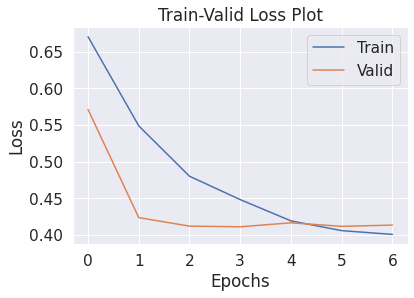

In [58]:
import matplotlib.pyplot as plt
epochs_=[]
for i in range(7):
    epochs_.append(i)
plt.plot(epochs_,train_loss,label='Train')
plt.plot(epochs_,valid_loss,label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train-Valid Loss Plot')
plt.legend()
plt.show()

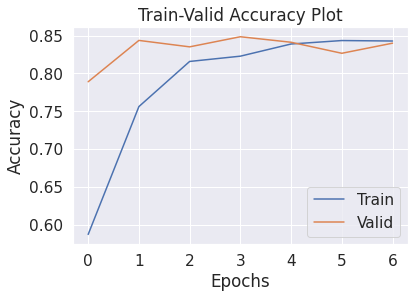

In [59]:
import matplotlib.pyplot as plt
epochs_=[]
for i in range(7):
    epochs_.append(i)
plt.plot(epochs_,train_acc,label='Train')
plt.plot(epochs_,valid_acc,label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train-Valid Accuracy Plot')
plt.legend()
plt.show()

### Model Testing

In [60]:
test_labels=[]
predicted_labels=[]

with torch.no_grad():
    test_acc, test_loss, test_count=0.0,0.0,0.0
    model.eval()
    for embedd, ans in test_loader:
        embedd=embedd.to(device)
        ans=ans.to(device)
        op=model(embedd)
        
        ypred=torch.round(torch.sigmoid(op)).squeeze()

        test_labels.extend(ans)
        predicted_labels.extend(ypred)

        l=criterion(op,ans.unsqueeze(1).float())

        test_acc+=torch.sum(ypred==ans)
        test_loss+=l.item()

        test_count+=1

    test_loss_score=test_loss/(test_count)

### Result Analysis

In [61]:
test_seq_labels=[]
for k in range(len(test_labels)):
    test_seq_labels.append(test_labels[k].to(device).item())

pred_seq_labels=[]
for k in range(len(predicted_labels)):
    pred_seq_labels.append(predicted_labels[k].to(device).item())

print('\033[1m Test Loss:  {0:0.4f}  Test Accuracy:  {1:0.4f} \033[0;0m'.format((test_loss_score),(accuracy_score(test_seq_labels,pred_seq_labels))))

 Test Loss:  0.3970  Test Accuracy:  0.8444 


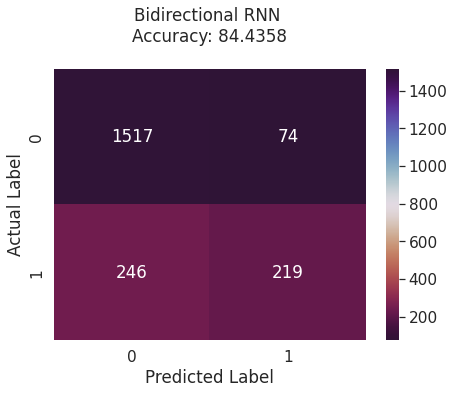

In [62]:
cm=confusion_matrix(test_seq_labels, pred_seq_labels)
cm_df=pd.DataFrame(cm, index=['0','1'],
                  columns=['0','1'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True,fmt='g',cmap="twilight_shifted_r")
plt.title('Bidirectional RNN \nAccuracy: {0:.4f}\n'.format(accuracy_score(test_seq_labels,pred_seq_labels)*100))
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [63]:
report = pd.DataFrame(classification_report(y_true = test_seq_labels, y_pred = pred_seq_labels, output_dict=True)).transpose()
report = report.rename(index={'0': '0','1':'1'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
0,86.05,95.35,90.46,1591.000000
1,74.74,47.10,57.78,465.000000
accuracy,84.44,84.44,84.44,0.844358
macro avg,80.40,71.22,74.12,2056.000000
weighted avg,83.49,84.44,83.07,2056.000000
